**Operations Research in Action &#x25aa; Fall 2024**

# Project 1 &ndash; Modeling

## Review the available data

- Recall that the purpose of this project is to forecast the monthly demand for beer based on a variety of factors.

* Let's refresh our memory and take a look at the data:

In [1]:
import pandas as pd

In [2]:
demand_price_df = pd.read_excel(
    './data/TablesA3A4.xlsx',
    sheet_name='Table A3',
    skiprows=3,
    nrows=84,
    header=None,
    names=[
        'Year',
        'Month',
        'BeerConsumption',
        'AvgBeerPrice',
        'AvgRakiPrice',
        'AvgCannedSoftDrinkPrice',
        'AvgCannedBeerPrice',
        'AvgDraftBeerPrice'
    ]
)

demand_price_df.head()

,Year,Month,BeerConsumption,AvgBeerPrice,AvgRakiPrice,AvgCannedSoftDrinkPrice,AvgCannedBeerPrice,AvgDraftBeerPrice
0,1987,January,13621800,1338.424656,9715.74,2208.12,2671.750,971.574039
1,1987,February,14346944,1314.441618,9460.31,2150.07,2866.475,946.031197
2,1987,March,14912839,1267.542544,9122.77,2073.36,2764.199,912.276950
3,1987,April,16129850,1241.471640,8935.13,2030.71,2707.345,893.513173
4,1987,May,12140503,1183.481067,8517.76,1935.85,2580.882,851.776142


In [3]:
tourist_df = pd.read_excel(
    './data/TablesA3A4.xlsx',
    sheet_name='Table A4',
    skiprows=3,
    header=None,
    names=[
        'Year',
        'Month',
        'Czechoslovakia',
        'Germany',
        'UnitedKingdom',
        'UnitedStates',
        'France',
        'Others'
    ]
)

tourist_df.head()

,Year,Month,Czechoslovakia,Germany,UnitedKingdom,UnitedStates,France,Others
0,1987,January,290,28056,11380,25060,9246,35135
1,1987,February,253,29715,20630,21648,11941,38488
2,1987,March,478,67370,30506,30386,15810,53071
3,1987,April,1025,271147,70016,43137,94247,141639
4,1987,May,2776,405921,165298,69696,155816,225780


In [4]:
ramadan_days_df = pd.read_excel(
    './data/FromCase.xlsx',
    sheet_name='RamadanDays'
)

ramadan_days_df.head()

,Year,Month,RamadanDays
0,1987,January,0
1,1987,February,0
2,1987,March,0
3,1987,April,2
4,1987,May,28


In [5]:
beer_consumption_df = pd.read_excel(
    './data/FromCase.xlsx',
    sheet_name='DailyBeerConsumption',
    index_col='Country'
)

beer_consumption_df.head()

,AvgDailyBeerConsumptionPerCapita
Country,
Czechoslovakia,0.446575
Germany,0.378082
UnitedKingdom,0.273973
UnitedStates,0.235616
Others,0.184395


## Brainstorming a linear regression model

- As we discussed earlier, we can use __linear regression__ to forecast monthly beer demand.

- Recall the linear regression model:

$$Y = \beta_0 + \beta_1 X_1 + \dots + \beta_k X_k + \varepsilon \qquad \varepsilon \sim \text{iid } N(0, \sigma_{\varepsilon}^2)$$

- $Y$ is the __response variable__, of the variable that measures the outcome of interest.

- $X_1, \dots, X_k$ are the __explanatory variables__, the variables whose relationship to the response variable is being studied. 

* What should we use as the response variable?

_Write your notes here. Double-click to edit._

_Solution._ We would ideally use the monthly beer demand as the response variable, since that is what we want to predict. However, we don't have that data. We can use monthly beer consumption as a proxy instead, as long as we keep in mind that we've made the assumption that consumption is roughly equal to demand.

* What should we use as the explanatory variables? 

_Write your notes here. Double-click to edit._

_Solution._ There are a number of variables that might influence monthly beer demand: 

- average beer price 
- average Raki price 
- average canned soft drink price 
- average canned beer price 
- average draft beer price 
- tourist beer consumption
- year (to control for long-term effects)
- month (to control for seasonal effects)
- number of Ramadan days in the month

## Data wrangling

* To run a linear regression model with all of these variables, we need to create a new single data frame that contains all of them.

* To do this, we'll need to do some basic __data wrangling__.

* First, let's create a series with the average daily beer consumption per capita for the different tourist countries of interest.

In [6]:
# Solution
avg_daily_beer_consumption_pc = beer_consumption_df['AvgDailyBeerConsumptionPerCapita']

avg_daily_beer_consumption_pc

Country
Czechoslovakia    0.446575
Germany           0.378082
UnitedKingdom     0.273973
UnitedStates      0.235616
Others            0.184395
France            0.106849
Name: AvgDailyBeerConsumptionPerCapita, dtype: float64

* Next, let's merge all the tables together, matching rows based on `Year` and `Month`.

* We can accomplish this using the `.merge()`  method of a Pandas DataFrame.

* [Here is the documentation for `.merge()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html).

* While we're at it, let's compute an estimate of the monthly tourist beer consumption.

In [7]:
# Solution
all_df = (
    demand_price_df
    .merge(tourist_df, on=['Year', 'Month'], how='left')
    .merge(ramadan_days_df, on=['Year', 'Month'], how='left')
    .assign(
        TouristBeerConsumption=lambda x: 
            x['Czechoslovakia'] * avg_daily_beer_consumption_pc['Czechoslovakia']
            + x['Germany'] * avg_daily_beer_consumption_pc['Germany'] 
            + x['UnitedKingdom'] * avg_daily_beer_consumption_pc['UnitedKingdom']
            + x['UnitedStates'] * avg_daily_beer_consumption_pc['UnitedStates'] 
            + x['France'] * avg_daily_beer_consumption_pc['France']
            + x['Others'] * avg_daily_beer_consumption_pc['Others']
    )
)

all_df.head()

,Year,Month,BeerConsumption,AvgBeerPrice,AvgRakiPrice,AvgCannedSoftDrinkPrice,AvgCannedBeerPrice,AvgDraftBeerPrice,Czechoslovakia,Germany,UnitedKingdom,UnitedStates,France,Others,RamadanDays,TouristBeerConsumption
0,1987,January,13621800,1338.424656,9715.74,2208.12,2671.750,971.574039,290,28056,11380,25060,9246,35135,0,27226.000715
1,1987,February,14346944,1314.441618,9460.31,2150.07,2866.475,946.031197,253,29715,20630,21648,11941,38488,0,30473.275998
2,1987,March,14912839,1267.542544,9122.77,2073.36,2764.199,912.276950,478,67370,30506,30386,15810,53071,0,52677.449434
3,1987,April,16129850,1241.471640,8935.13,2030.71,2707.345,893.513173,1025,271147,70016,43137,94247,141639,2,168507.661703
4,1987,May,12140503,1183.481067,8517.76,1935.85,2580.882,851.776142,2776,405921,165298,69696,155816,225780,28,274701.483979


## Regression model building and analysis 

* We can run R code in a Python Jupyter notebook using the [rpy2](https://rpy2.github.io/) package.

* We import rpy2 and activate the Jupyter interface like this:

In [8]:
import rpy2
%load_ext rpy2.ipython

* To run R code in a cell, start the cell with `%%R`.

* For example, to load the [olsrr](https://olsrr.rsquaredacademy.com/) library (which we will use shortly) and set the display width to 100, we can do this: 

In [9]:
%%R 
library(olsrr)
options(width=100)


Attaching package: ‘olsrr’

The following object is masked from ‘package:datasets’:

    rivers



### Model 1

* Let's start by fitting a linear regression model that includes all the variables we discussed above.

* To "push" a Pandas DataFrame into the R workspace, we pass the `-i <name of DataFrame>` option to `%%R`.

* Recall that we can explicitly set the order of a categorical variable ("factor" in R parlance) with the `factor()` function in R.

In [10]:
%%R -i all_df 
# Solution
all_df$Month <- factor(
    all_df$Month, 
    levels = c('January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December')
) 

fit <- lm(
    BeerConsumption
    ~
    AvgBeerPrice
    + AvgRakiPrice
    + AvgCannedSoftDrinkPrice
    + AvgCannedBeerPrice
    + AvgDraftBeerPrice
    + TouristBeerConsumption
    + RamadanDays
    + Year
    + Month,
    data = all_df 
)

summary(fit)


Call:
lm(formula = BeerConsumption ~ AvgBeerPrice + AvgRakiPrice + 
    AvgCannedSoftDrinkPrice + AvgCannedBeerPrice + AvgDraftBeerPrice + 
    TouristBeerConsumption + RamadanDays + Year + Month, data = all_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-6441051 -1814349  -342782  2104359  6623692 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -6.457e+09  9.950e+08  -6.490 1.45e-08 ***
AvgBeerPrice            -2.457e+04  8.028e+03  -3.061 0.003227 ** 
AvgRakiPrice             1.263e+02  5.304e+02   0.238 0.812504    
AvgCannedSoftDrinkPrice  1.622e+03  4.474e+03   0.362 0.718224    
AvgCannedBeerPrice      -1.535e+03  4.528e+03  -0.339 0.735767    
AvgDraftBeerPrice        1.263e+04  1.004e+04   1.258 0.212896    
TouristBeerConsumption   2.205e+01  6.198e+00   3.558 0.000709 ***
RamadanDays             -3.188e+05  7.827e+04  -4.073 0.000130 ***
Year                     3.264e+06  4.998e+05   6.531 1.23e-08 **

### Best subsets regression

- We see that some of the predictors in Model 1 are not statistically significant.

- Recall that removing or adding a predictor to a linear regression model will affect the statistical significance of the other predictors.

- How do we know which predictors to keep?

- __Best subsets regression__ chooses predictors by comparing _all possible subsets of predictors_ according to some metric.

- There are a number of metrics that could be used to compare the fit of different regression models.

- We will use __Akaike's information criterion (AIC)__, which is popular among practicing statisticians.

- Lower values of AIC $\leftrightarrow$ model is more preferred.

- We can perform best subsets regression using `ols_step_best_subset()` from the olsrr package, like this:

In [11]:
%%R
# Solution
ols_step_best_subset(fit, metric='aic')

                                                              Best Subsets Regression                                                              
---------------------------------------------------------------------------------------------------------------------------------------------------
Model Index    Predictors
---------------------------------------------------------------------------------------------------------------------------------------------------
     1         TouristBeerConsumption                                                                                                               
     2         Year Month                                                                                                                           
     3         TouristBeerConsumption Year Month                                                                                                    
     4         AvgBeerPrice TouristBeerConsumption Year Month                      

* According to the AIC, which model gives us the best fit?

_Write your notes here. Double-click to edit._

_Solution._ Model 6 has the lowest AIC.

### Model 2

* Let's fit the best model according to AIC:


In [12]:
%%R
# Solution
best_fit <- lm(
    BeerConsumption
    ~
    AvgBeerPrice
    + AvgDraftBeerPrice
    + TouristBeerConsumption
    + RamadanDays
    + Year
    + Month,
    data = all_df 
)

summary(best_fit)


Call:
lm(formula = BeerConsumption ~ AvgBeerPrice + AvgDraftBeerPrice + 
    TouristBeerConsumption + RamadanDays + Year + Month, data = all_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-6592476 -1859240  -216914  2166354  6604799 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -6.658e+09  5.490e+08 -12.128  < 2e-16 ***
AvgBeerPrice           -2.690e+04  6.306e+03  -4.265 6.42e-05 ***
AvgDraftBeerPrice       1.343e+04  8.741e+03   1.537 0.129107    
TouristBeerConsumption  2.307e+01  4.845e+00   4.762 1.07e-05 ***
RamadanDays            -3.167e+05  7.489e+04  -4.228 7.30e-05 ***
Year                    3.366e+06  2.753e+05  12.228  < 2e-16 ***
MonthFebruary          -1.798e+05  1.740e+06  -0.103 0.918000    
MonthMarch              4.994e+06  1.890e+06   2.643 0.010235 *  
MonthApril              1.770e+06  2.294e+06   0.772 0.443013    
MonthMay                6.491e+06  2.813e+06   2.308 0.024113 *  
MonthJune

* Let's check the diagnostic plots:

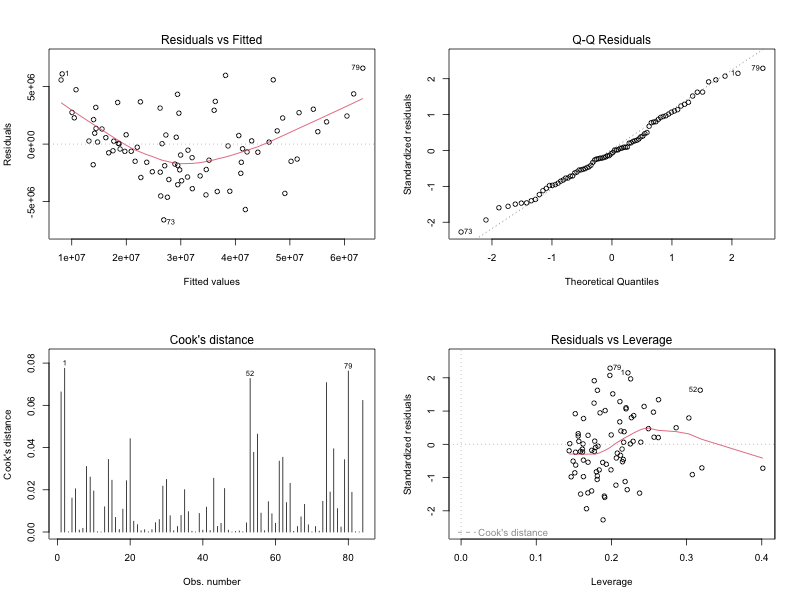

In [13]:
%%R -w 800 -h 600
# Solution
par(mfrow=c(2, 2))
plot(best_fit, which=1)
plot(best_fit, which=2)
plot(best_fit, which=4)
plot(best_fit, which=5)

* Let's also compute the __variance inflation factors (VIFs)__ to detect multicollinearity.

* We can do this using the `ols_vif_tol()` function from the olsrr package, like this:

In [14]:
%%R
# Solution
ols_vif_tol(best_fit)

                Variables Tolerance      VIF
1            AvgBeerPrice 0.4030035 2.481368
2       AvgDraftBeerPrice 0.3591388 2.784438
3  TouristBeerConsumption 0.1060114 9.432952
4             RamadanDays 0.5062031 1.975492
5                    Year 0.4075691 2.453572
6           MonthFebruary 0.5341097 1.872275
7              MonthMarch 0.4527232 2.208855
8              MonthApril 0.3072742 3.254423
9                MonthMay 0.2043861 4.892700
10              MonthJune 0.2229413 4.485485
11              MonthJuly 0.2005803 4.985535
12            MonthAugust 0.1863028 5.367605
13         MonthSeptember 0.1984187 5.039848
14           MonthOctober 0.2845077 3.514844
15          MonthNovember 0.5216216 1.917099
16          MonthDecember 0.5399519 1.852017


* Assess this model using the the diagnostic plots and VIFs. If there are any issues, suggest a remedy.

_Write your notes here. Double-click to edit._

_Solution._

- Residuals vs. fitted plot indicates that linearity appears to be violated.

- We also have multicollinearity issues: the VIF of WeightedTouristBeerConsumption is greater than 5.

- Let's try using log(BeerConsumption) as the response variable instead.

### Model 3

- Let's start again with all the possible explanatory variables, but this time, with the transformed response variable.

In [15]:
%%R
# Solution
all_df$logBeerConsumption <- log(all_df$BeerConsumption)

logfit <- lm(
    logBeerConsumption
    ~
    AvgBeerPrice
    + AvgRakiPrice
    + AvgCannedSoftDrinkPrice
    + AvgCannedBeerPrice
    + AvgDraftBeerPrice
    + TouristBeerConsumption
    + RamadanDays
    + Year
    + Month,
    data = all_df 
)

summary(logfit)


Call:
lm(formula = logBeerConsumption ~ AvgBeerPrice + AvgRakiPrice + 
    AvgCannedSoftDrinkPrice + AvgCannedBeerPrice + AvgDraftBeerPrice + 
    TouristBeerConsumption + RamadanDays + Year + Month, data = all_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.21483 -0.03829  0.00152  0.03871  0.15605 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -2.425e+02  2.421e+01 -10.015 9.94e-15 ***
AvgBeerPrice            -6.152e-04  1.954e-04  -3.149  0.00249 ** 
AvgRakiPrice            -8.309e-06  1.291e-05  -0.644  0.52198    
AvgCannedSoftDrinkPrice  1.833e-04  1.089e-04   1.683  0.09716 .  
AvgCannedBeerPrice      -5.388e-05  1.102e-04  -0.489  0.62655    
AvgDraftBeerPrice        3.980e-04  2.443e-04   1.629  0.10829    
TouristBeerConsumption   1.254e-07  1.508e-07   0.831  0.40882    
RamadanDays             -1.420e-02  1.905e-03  -7.455 2.94e-10 ***
Year                     1.304e-01  1.216e-02  10.721 6.32e-16

### Best subsets regression, again

- Next, let's perform best subsets regression to identify the best collection of predictors, based on AIC.

In [16]:
%%R
# Solution
ols_step_best_subset(logfit, metric='aic')

                                                              Best Subsets Regression                                                              
---------------------------------------------------------------------------------------------------------------------------------------------------
Model Index    Predictors
---------------------------------------------------------------------------------------------------------------------------------------------------
     1         TouristBeerConsumption                                                                                                               
     2         Year Month                                                                                                                           
     3         RamadanDays Year Month                                                                                                               
     4         AvgBeerPrice RamadanDays Year Month                                 

### Model 4

- Let's examine the best subsets regression by AIC.

In [17]:
%%R
# Solution
best_logfit <- lm(
    logBeerConsumption
    ~
    AvgBeerPrice
    + AvgCannedSoftDrinkPrice
    + AvgDraftBeerPrice
    + TouristBeerConsumption
    + RamadanDays
    + Year
    + Month,
    data = all_df 
)

summary(best_logfit)


Call:
lm(formula = logBeerConsumption ~ AvgBeerPrice + AvgCannedSoftDrinkPrice + 
    AvgDraftBeerPrice + TouristBeerConsumption + RamadanDays + 
    Year + Month, data = all_df)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.225199 -0.041333 -0.003322  0.041210  0.160711 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -2.502e+02  1.589e+01 -15.750  < 2e-16 ***
AvgBeerPrice            -6.380e-04  1.594e-04  -4.002 0.000161 ***
AvgCannedSoftDrinkPrice  1.354e-04  6.695e-05   2.023 0.047165 *  
AvgDraftBeerPrice        3.219e-04  2.183e-04   1.474 0.145133    
TouristBeerConsumption   1.815e-07  1.213e-07   1.497 0.139236    
RamadanDays             -1.391e-02  1.843e-03  -7.550 1.69e-10 ***
Year                     1.343e-01  7.935e-03  16.919  < 2e-16 ***
MonthFebruary            4.220e-02  4.286e-02   0.985 0.328432    
MonthMarch               3.359e-01  4.717e-02   7.122 9.83e-10 ***
MonthApril           

* Are you satisfied with this model? Why or why not?

_Write your notes here. Double-click to edit._

*Solution.*

- Looking at Model 4, we see that AvgDraftBeerPrice and TouristBeerConsumption are not statistically significant.

- Let's take them out. Note that this gives us the best regression with 5 predictors (see best subsets table above).

### Model 5

- Let's examine the best subsets regression by AIC with 5 predictors.

In [18]:
%%R
# Solution
best5_logfit <- lm(
    logBeerConsumption
    ~
    AvgBeerPrice
    + AvgCannedSoftDrinkPrice
    + RamadanDays
    + Year
    + Month,
    data = all_df 
)

summary(best5_logfit)


Call:
lm(formula = logBeerConsumption ~ AvgBeerPrice + AvgCannedSoftDrinkPrice + 
    RamadanDays + Year + Month, data = all_df)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.212113 -0.052371 -0.001813  0.053253  0.156207 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -2.567e+02  1.200e+01 -21.386  < 2e-16 ***
AvgBeerPrice            -4.977e-04  1.196e-04  -4.162 9.08e-05 ***
AvgCannedSoftDrinkPrice  1.747e-04  6.572e-05   2.658  0.00979 ** 
RamadanDays             -1.446e-02  1.808e-03  -7.997 2.22e-11 ***
Year                     1.375e-01  5.971e-03  23.030  < 2e-16 ***
MonthFebruary            4.102e-02  4.367e-02   0.939  0.35082    
MonthMarch               3.540e-01  4.684e-02   7.557 1.39e-10 ***
MonthApril               2.796e-01  4.861e-02   5.751 2.30e-07 ***
MonthMay                 5.993e-01  4.540e-02  13.200  < 2e-16 ***
MonthJune                7.858e-01  4.427e-02  17.749  < 2e-16 ***
Mont

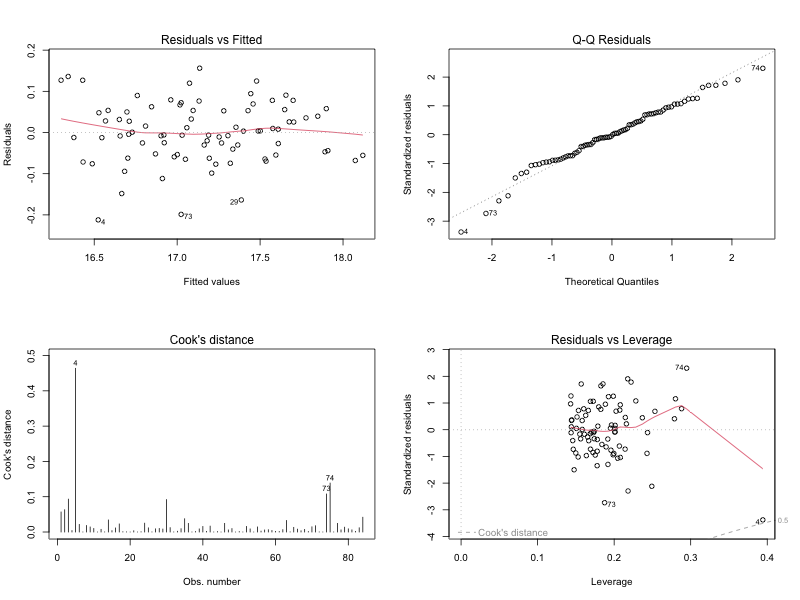

In [19]:
%%R -w 800 -h 600 
# Solution
par(mfrow=c(2, 2))
plot(best5_logfit, which=1)
plot(best5_logfit, which=2)
plot(best5_logfit, which=4)
plot(best5_logfit, which=5)

In [20]:
%%R 
# Solution
ols_vif_tol(best5_logfit)

                 Variables Tolerance      VIF
1             AvgBeerPrice 0.7035491 1.421365
2  AvgCannedSoftDrinkPrice 0.4621086 2.163994
3              RamadanDays 0.5450715 1.834622
4                     Year 0.5438136 1.838866
5            MonthFebruary 0.5323949 1.878305
6               MonthMarch 0.4627657 2.160921
7               MonthApril 0.4297176 2.327110
8                 MonthMay 0.4924821 2.030531
9                MonthJune 0.5180137 1.930451
10               MonthJuly 0.4920505 2.032312
11             MonthAugust 0.5086548 1.965970
12          MonthSeptember 0.5271079 1.897145
13            MonthOctober 0.5351536 1.868622
14           MonthNovember 0.5262080 1.900389
15           MonthDecember 0.5400055 1.851833


* Assess this model using the the diagnostic plots and VIFs. If there are any issues, suggest a remedy.

_Write your notes here. Double-click to edit._

_Solution._

- Residuals vs. fitted plot indicates that linearity and equal variance are reasonably satisfied.

- Normal QQ plot indicates that the residuals are approximately normally distributed.

- Multicollinearity does not appear to be an issue, since the VIFs are all below 5.